In [5]:
import os
import sys
sys.path.insert(0, os.path.join(os.getenv("HOME"), "linked-data-latex"))

import logging
logging.basicConfig(level="INFO")

import pandas as pd
from matplotlib import pylab as plt
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord

In [6]:
# oda:version "v0.1.11"

In [7]:
from odafunction.executors import default_execute_to_value
from odafunction.func.urifunc import URIipynbFunction, URIValue

focus_obs_name='total_3p'

# TODO: set version restriction here
# TODO: make nb2workflow store in remote storages
# TODO: make possible to disrupt equivalence with indications
# TODO: make common fd/fc depending on

v = default_execute_to_value(URIipynbFunction.from_generic_uri("file:///home/savchenk/grb221009/grbbase.ipynb")(focus_obs_name=focus_obs_name), valueclass=URIValue, cached=True)

import io
import tempfile
import base64
import tarfile
    
with tarfile.open(v['output_values']['fits_pack_url'].replace("file://", "")) as tar:
    tar.extractall(path=f"grbbase_fitspack_{focus_obs_name}")

!ls -ltor grbbase_fitspack*/*fits

INFO:odafunction.func.urifunc:constructing <class 'odafunction.func.urifunc.URIipynbFunction'> from uri=file:///home/savchenk/grb221009/grbbase.ipynb value=None provenance=None
INFO:odafunction.func.urifunc:parsing URI file:///home/savchenk/grb22100...(45)
INFO:odafunction.func.urifunc:parsed uri file:///home/savchenk/grb221009/grbbase.ipynb as {'modifier': None, 'schema': 'file', 'path': '/home/savchenk/grb221009/grbbase.ipynb', 'funcname': None, 'revision': None}
INFO:nb2workflow.nbadapter:notebook_dir: /home/savchenk/grb221009
INFO:nb2workflow.semantics:input combined turtle: @prefix oda: <http://odahub.io/ontology#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix unit: <http://odahub.io/ontology/unit#> .


<http://odahub.io/ontology#grbbase_0d90e830> a oda:version "v0.2.25" .
INFO:nb2workflow.semantics:this variation could not be parsed: <http://odahub.i

-rw-rw-r-- 1 savchenk  4472640 Feb 10 23:14 grbbase_fitspack_total_3p/isgri_total_3p_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10 23:14 grbbase_fitspack_total_3p/jemx1_total_3p_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10 23:14 grbbase_fitspack_total_3p/jemx2_total_3p_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10 23:18 grbbase_fitspack_total_3p/jemx1_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10 23:18 grbbase_fitspack_total_3p/jemx2_mosaic.fits
-rw-rw-r-- 1 savchenk  4472640 Feb 10 23:18 grbbase_fitspack_total_3p/isgri_mosaic.fits
-rw-rw-r-- 1 savchenk  4472640 Feb 10 23:18 grbbase_fitspack_total_3p/isgrihe_mosaic.fits
-rw-rw-r-- 1 savchenk    23040 Feb 10 23:18 grbbase_fitspack_total_3p/JMX1_lc_GRB221009A.fits
-rw-rw-r-- 1 savchenk    23040 Feb 10 23:18 grbbase_fitspack_total_3p/JMX2_lc_GRB221009A.fits
-rw-rw-r-- 1 savchenk    28800 Feb 10 23:18 grbbase_fitspack_total_3p/IBIS_lc_GRB221009A.fits
-rw-rw-r-- 1 savchenk    17280 Feb 10 23:18 grbbase_fitspack_total_3p/JMX

In [8]:
vacs = default_execute_to_value(URIipynbFunction.from_generic_uri("file:///home/savchenk/grb221009/acs.ipynb"), valueclass=URIValue, cached=True)
import pandas as pd
acslc = pd.read_csv(vacs['output_values']['acslc_csv_url'].replace("file://", ""))

INFO:odafunction.func.urifunc:constructing <class 'odafunction.func.urifunc.URIipynbFunction'> from uri=file:///home/savchenk/grb221009/acs.ipynb value=None provenance=None
INFO:odafunction.func.urifunc:parsing URI file:///home/savchenk/grb22100...(41)
INFO:odafunction.func.urifunc:parsed uri file:///home/savchenk/grb221009/acs.ipynb as {'modifier': None, 'schema': 'file', 'path': '/home/savchenk/grb221009/acs.ipynb', 'funcname': None, 'revision': None}
INFO:nb2workflow.nbadapter:notebook_dir: /home/savchenk/grb221009
INFO:nb2workflow.semantics:input combined turtle: @prefix oda: <http://odahub.io/ontology#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix unit: <http://odahub.io/ontology/unit#> .


<http://odahub.io/ontology#acs_0d90e830> a oda:version "v0.1.3" .
INFO:nb2workflow.semantics:this variation could not be parsed: <http://odahub.io/ontology#acs_0d

In [9]:
from astropy.time import Time

T0_isot = v['output_values']['data']['T0_isot']
T0_ijd = Time(T0_isot).mjd - 51544

# TODO: import from other wfl
src_coord = SkyCoord("19h 13m 03.43s", "+19d 46m 23.1s", unit=u.deg)


In [10]:

from ddpaper.draftdata import load_globals

load_globals("eventinfo", globals())


INFO:ddpaper.draftdata:can not open ./draftdata/eventinfo.yaml due to [Errno 2] No such file or directory: './draftdata/eventinfo.yaml' FileNotFoundError(2, 'No such file or directory'), will create a new one


        59861.532764       -1.132263e-08
        59861.532875       -2.860962e-08
        59861.532967        8.372585e-09
        59861.533060        2.639475e-08
        59861.533152        5.800138e-08
        59861.533243        7.682774e-09
        59861.533336       -2.288027e-08
        59861.533427       -2.711575e-08
        59861.533519       -1.538258e-09
        59861.533612       -4.196331e-08


[]

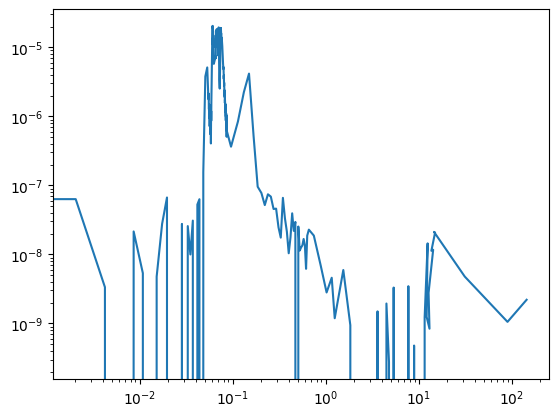

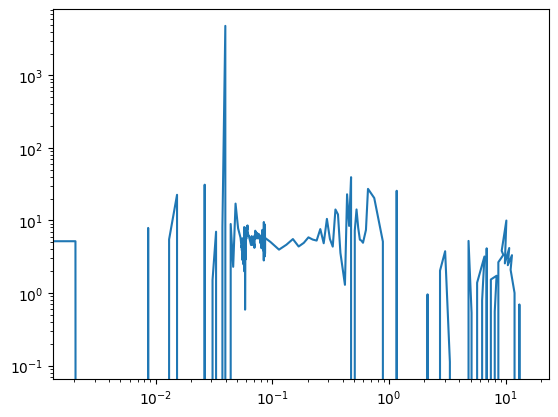

In [11]:
plt.figure()

!head picsit/grb221009a_afterglow_picsit_lc.txt

picsit_lc = pd.read_csv("picsit/grb221009a_afterglow_picsit_lc.txt", delim_whitespace=True, names=["mjd", "flux"])
picsit_hr = pd.read_csv("picsit/grb221009a_afterglow_picsit_hr.txt", delim_whitespace=True, names=["mjd", "hr"])

plt.plot(
    (picsit_lc.mjd - (T0_ijd + 51544))*24, 
    picsit_lc.flux, 
)

plt.loglog()

plt.figure()

plt.plot(
    (picsit_hr.mjd - (T0_ijd + 51544))*24, 
    picsit_hr.hr, 
)

plt.loglog()

In [12]:
import numpy as np
from rebin import rebin_in_bins



In [13]:
picsit_lc.sort_values('mjd', inplace=True)

picsit_lc['flux_err'] = picsit_lc.flux*0 + 1e-8
picsit_lc['dt']  = np.concatenate([[0], np.array(picsit_lc['mjd'])[1:] - np.array(picsit_lc['mjd'])[:-1]])

In [14]:
import subprocess
import io
import pathlib
from astropy.io import fits

def sshopen(fn):
    cfn = pathlib.Path("/tmp/sshopen-cache/") / fn.replace("/", "_")
    cfn.parent.mkdir(exist_ok=True)

    try:
        of = fits.open(cfn)
    except:
        f = io.BytesIO(subprocess.check_output(f"ssh login01.astro.unige.ch tar cf - {fn} | tar xf - -O", shell=True))

        with open(cfn, "wb") as F:
            F.write(f.read())
        
        of = fits.open(cfn)
    return of

sshopen("/isdc/arc/rev_3/scw/2558/255800290010.001/compton_events.fits.gz")


tar: Removing leading `/' from member names


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fccb1b7d310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fccb1b8ea60>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fccb1b8ee20>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fccb1b8e190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fccb1b8eeb0>]

tar: Removing leading `/' from member names
tar: Removing leading `/' from member names
tar: Removing leading `/' from member names
tar: Removing leading `/' from member names


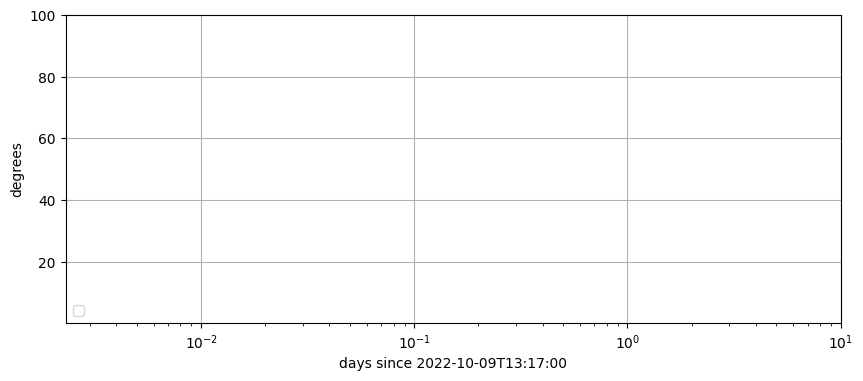

In [15]:
ijd2plot = lambda T: (T - T0_ijd)*24*3600
ijd2plot_d = lambda T: (T - T0_ijd)

att_hist = None

for orbit in ["2558", "2559", "2560", "2561"]:
    _ = sshopen(f"/isdc/arc/rev_3/aux/adp/{orbit}.001/attitude_historic.fits.gz")[1].data
    if att_hist is None:
        att_hist = _
    else:
        att_hist = np.concatenate([att_hist, _])



scx = SkyCoord(att_hist['RA_SCX'], att_hist['DEC_SCX'], unit="deg")
scz = SkyCoord(att_hist['RA_SCZ'], att_hist['DEC_SCZ'], unit="deg")

theta = scx.separation(src_coord).deg

plt.figure(figsize=(10, 4))


def plot_obs():
    plt.step(
    # plt.scatter(
        ijd2plot_d(att_hist['TIME']),
        # att_hist['RA_SCX'],
        # att_hist['DEC_SCX']
        theta,
        where="pre",
        label="source - SCX (FoV)",
        lw=2
    )

    plt.step(
        ijd2plot_d(att_hist['TIME']),
        -1 * scz.separation(src_coord).deg + 180,
        label="source - SCZ (IBIS to SPI)",
        where='pre',
        lw=2
    )

    # m_stable_ons_response = theta > 60
    m_stable_ons_response = ijd2plot_d(att_hist['POINTING_TIME']) - att_hist['DURATION']/24/3600 < 0.1
    m_stable_ons_response &= ijd2plot_d(att_hist['POINTING_TIME']) > -0.1



    plt.axhspan(0, 5, color='green', alpha=0.3, 
                # label='< 5 deg, FoV observations with ISGRI and JEM-X'
                )
    # plt.axhspan(5, 10, color='yellow', alpha=0.3)

    plt.axhspan(theta[m_stable_ons_response].min(), theta[m_stable_ons_response].max(), color='grey', alpha=0.3,
                # label="range of relative source angles with stable all-sky response"
                )
    

    return m_stable_ons_response


plt.xlim([200/24/3600, 10])
plt.ylim([0.1, 100])

# plt.loglog()
plt.semilogx()

plt.legend(loc='lower left')

plt.xlabel(f"days since {T0_isot}")
plt.ylabel(f"degrees")

plt.grid()

plt.savefig("relpos_history.pdf")

In [16]:
att_hist

array([(b'25580000', b'P', b'P', 0, 8316.73990954, 8316.73990954, 8316.73990954, 1.157035e+04, 0., 315.00226, -34.99975  , 210.64058, -19.506361, b'            ',   0.     , 0.       , 111.2, 0, nan,        nan,        nan),
       (b'25580001', b'O', b'M', 0, 8316.87382157, 8316.87894889, 8316.87465491, 0.000000e+00, 0., 316.01096, -36.77675  , 210.02783, -20.223055, b'            ',   0.     , 0.       , 111. , 0, nan,        nan,        nan),
       (b'25580001', b'O', b'M', 1, 8316.87382157, 8316.87894889, 8316.87512944, 0.000000e+00, 0., 316.89224, -38.214638 , 209.46721, -20.823944, b'            ',   0.     , 0.       , 111. , 0, nan,        nan,        nan),
       ...,
       (b'25610077', b'P', b'G', 0, 8327.24341648, 8327.24526833, 8327.26026833, 2.100000e+02, 0., 152.00063,   2.997611 , 241.2125 , -14.717639, b'0244-00053-1', 151.5325 , 2.4294446,  53. , 0, 0.3,  6.205e-04, -0.0023855),
       (b'25610077', b'P', b'G', 0, 8327.24341648, 8327.24526833, 8327.26269889, 2.69990

In [17]:
"""
obs1 (1-1.7 days, 8 rings):
 Model Flux 0.0014555 photons (1.0229e-11 ergs/cm^2/s) range (3.0000 - 10.000 keV)
 Model Flux 3.7829e-05 photons (7.6619e-13 ergs/cm^2/s) range (10.000 - 20.000 keV)
 Model Flux 3.359e-06 photons (1.455e-13 ergs/cm^2/s) range (20.000 - 100.00 keV)

obs2 (2-3.5 days, 4 rings):
 Model Flux 0.00027077 photons (1.8924e-12 ergs/cm^2/s) range (3.0000 - 10.000 keV)
 Model Flux 6.3803e-06 photons (1.2892e-13 ergs/cm^2/s) range (10.000 - 20.000 keV)
 Model Flux 5.4611e-07 photons (2.3622e-14 ergs/cm^2/s) range (20.000 - 100.00 keV)

obs3 (5.3-6.6 days, 2 rings):
 Model Flux 4.473e-05 photons (3.0338e-13 ergs/cm^2/s) range (3.0000 - 10.000 keV)
 Model Flux 7.8889e-07 photons (1.5892e-14 ergs/cm^2/s) range (10.000 - 20.000 keV)
 Model Flux 6.4597e-08 photons (2.7899e-15 ergs/cm^2/s) range (20.000 - 100.00 keV)
"""

'\nobs1 (1-1.7 days, 8 rings):\n Model Flux 0.0014555 photons (1.0229e-11 ergs/cm^2/s) range (3.0000 - 10.000 keV)\n Model Flux 3.7829e-05 photons (7.6619e-13 ergs/cm^2/s) range (10.000 - 20.000 keV)\n Model Flux 3.359e-06 photons (1.455e-13 ergs/cm^2/s) range (20.000 - 100.00 keV)\n\nobs2 (2-3.5 days, 4 rings):\n Model Flux 0.00027077 photons (1.8924e-12 ergs/cm^2/s) range (3.0000 - 10.000 keV)\n Model Flux 6.3803e-06 photons (1.2892e-13 ergs/cm^2/s) range (10.000 - 20.000 keV)\n Model Flux 5.4611e-07 photons (2.3622e-14 ergs/cm^2/s) range (20.000 - 100.00 keV)\n\nobs3 (5.3-6.6 days, 2 rings):\n Model Flux 4.473e-05 photons (3.0338e-13 ergs/cm^2/s) range (3.0000 - 10.000 keV)\n Model Flux 7.8889e-07 photons (1.5892e-14 ergs/cm^2/s) range (10.000 - 20.000 keV)\n Model Flux 6.4597e-08 photons (2.7899e-15 ergs/cm^2/s) range (20.000 - 100.00 keV)\n'

In [18]:
import ogip.core
import ogip.tools

import importlib

importlib.reload(ogip.tools)


def get_conversion(instr):
    pha = ogip.core.open_something(f"grbbase_fitspack_{focus_obs_name}/{instr}_spectrum_GRB221009A_{focus_obs_name}.fits")
    rmf = ogip.core.open_something(f"grbbase_fitspack_{focus_obs_name}/{instr}_rmf_GRB221009A_{focus_obs_name}.fits")
    arf = ogip.core.open_something(f"grbbase_fitspack_{focus_obs_name}/{instr}_arf_GRB221009A_{focus_obs_name}.fits")


    model_generator = lambda p:(lambda x:(p[0]*(x/25.)))
    fit_result, fitted_model = ogip.tools.fit(model_generator, [7e-5], pha, rmf, None, 
                                            mask=~np.isnan(pha._rate))

    # TODO: check
    return ogip.tools.get_unfolding_factor(fitted_model, rmf, arf) * u.keV.to(u.erg)


get_conversion('IBIS').mean(), 1e-8/200

INFO:root:opened grbbase_fitspack_total_3p/IBIS_spectrum_GRB221009A_total_3p.fits as <ogip.spec.PHAI object at 0x7fcca0d416d0>
INFO:root:opened grbbase_fitspack_total_3p/IBIS_rmf_GRB221009A_total_3p.fits as <ogip.spec.RMF object at 0x7fcca0ce12e0>
INFO:root:opened grbbase_fitspack_total_3p/IBIS_arf_GRB221009A_total_3p.fits as <ogip.spec.ARF object at 0x7fcca0c5a550>


AttributeError: module 'ogip.tools' has no attribute 'fit'

In [ ]:
from astropy.io import fits


T = np.logspace(-1, 1, 120)
Tc = (T[1:] + T[:-1])/2.
dT = (T[1:] - T[:-1])/2.

# plt.figure(figsize=(16, 6))
f, axes = plt.subplots(2, 1, figsize=(16, 8), height_ratios=[3, 1], sharex=True)
plt.sca(axes[0])

ijd2plot = lambda t:(t- T0_ijd)

plt.axhline(0, lw=2, c='k', alpha=0.5)


for label, n in [('IBIS', 'IBIS'),
                 ('JEM-X1', 'JMX1'),
                 ('JEM-X2', 'JMX2')
                ]:

    f = fits.open(f"grbbase_fitspack_total_3p/{n}_lc_GRB221009A.fits")
    d = f[1].data
    conversion_factor = get_conversion('JMX1').mean()

    # plt.errorbar(ijd2plot(isgri_lc['TIME']), isgri_lc['RATE'], isgri_lc['ERROR'])

    d['RATE'][d['ERROR'] > np.nanmedian(d['ERROR'])*10] = np.NaN    

    r = rebin_in_bins(d['TIME'] - T0_ijd, d['RATE'], T)
    re = rebin_in_bins(d['TIME'] - T0_ijd, d['ERROR'], T, agg=lambda x:(np.sum(x**2))**0.5/len(x))

    m = re < np.nanmedian(re)*3

    factor = 1e-8/200
    factor = conversion_factor

    plt.errorbar(
        Tc[m], 
        r[m]*factor,
        re[m]*factor,
        xerr=dT[m],
        label=f"{label} {int(f[1].header['E_MIN']):d} - {int(f[1].header['E_MAX']):d} keV",
        ls=""
    )

m = (picsit_lc.mjd - (T0_ijd + 51544)) < 0.1

plt.errorbar(
    (picsit_lc.mjd - (T0_ijd + 51544))[m], 
    picsit_lc.flux[m],
    picsit_lc.flux_err[m],
    xerr=picsit_lc.dt[m]/2,
    ls="",
    label='PICsIT > 250 keV'
)

n = 1000

def rebin(x, n):
    N = int(len(x)/n)
    return np.array(x[:N*n]).reshape((N, n)).sum(1)


## ACS
# TODO: check values
bkg = 5336.468053846153
cts_to_fluence = 3e-10
t_acs_offset = 70./24/3600

tail_change = 0.01
tail_bins = np.logspace(-3, -1, 200)

acs_T = np.concatenate([np.linspace(0, tail_change, int(tail_change/0.1)), tail_bins])
acs_Tc = (acs_T[1:] + acs_T[:-1])/2.
acs_dT = (acs_T[1:] - acs_T[:-1])/2.

from rebin import rebin_in_bins, rebin_bins_in_bins


acs_C = rebin_in_bins(acslc.t - T0_ijd, acslc.c - bkg - acslc.bkg_mean, acs_T, agg=lambda x:(np.sum(x))/len(x))
acs_Cmin = rebin_in_bins(acslc.t - T0_ijd, acslc.c - bkg - acslc.bkg_max, acs_T, agg=lambda x:(np.sum(x))/len(x))
acs_Cmax = rebin_in_bins(acslc.t - T0_ijd, acslc.c - bkg - acslc.bkg_min, acs_T, agg=lambda x:(np.sum(x))/len(x))

c = None

c = plt.plot(
    acs_Tc- t_acs_offset,
    acs_C * cts_to_fluence,
    lw=2,
    label="SPI-ACS"
)[0].get_color()


c = plt.fill_between(
    acs_Tc - t_acs_offset,
    acs_Cmin * cts_to_fluence,
    acs_Cmax * cts_to_fluence,
    lw=2,
    color=c,
    alpha=0.3
)


# c = plt.plot(
#     (rebin(acslc.t, n)/n - T0_ijd) - t_acs_offset,
#     rebin(acslc.c - acslc.bkg_mean - bkg, n)/n * cts_to_fluence,
#     lw=2
# )[0].get_color()

# plt.fill_between(
#     (rebin(acslc.t, n)/n - T0_ijd) - t_acs_offset,
#     rebin(acslc.c - acslc.bkg_max - bkg, n)/n * cts_to_fluence,
#     rebin(acslc.c - acslc.bkg_min - bkg, n)/n * cts_to_fluence,
#     color=c
# )

# TODO: picsit erange

plt.ylim([0.5e-12, 1e-4])
plt.ylabel("flux, erg cm$^{-2}$ s$^{-1}$")
plt.loglog()
plt.grid()
plt.legend()

plt.sca(axes[1])

m_stable_ons_response = plot_obs()

plt.ylabel("degrees")
plt.ylim([0, 100])
plt.xlim([100./24/3600, 10])

# plt.grid(which='both')
plt.grid()

plt.legend(loc="lower left")

plt.xlabel(f"days since {T0_isot}")

plt.subplots_adjust(hspace=0)
# plt.semilogx()

plt.savefig("lc.png")
plt.savefig("lc.pdf")

# TODO: plot early AG SPI-ACS
# TODO: plot model fitb
# TODO: plot rings contribution approx



In [ ]:
acs_T

In [ ]:
(acs_T[1:] - acs_T[:-1])*24*3600

In [ ]:
lc_pdf = "lc.pdf"
relpos_history_pdf = "relpos_history.pdf"
comment_reconstruction = "assuming slope of -2"
theta_ons_min = theta[m_stable_ons_response].min()
theta_ons_max = theta[m_stable_ons_response].max()
approx_ons_t1_isot = Time(att_hist['POINTING_TIME'][m_stable_ons_response].min() + 51544, format='mjd').isot
approx_ons_t1_rel_d = att_hist['POINTING_TIME'][m_stable_ons_response].min() - T0_ijd
approx_ons_t2_isot = Time(att_hist['POINTING_TIME'][m_stable_ons_response].max() + 51544, format='mjd').isot
approx_ons_t2_rel_d = att_hist['POINTING_TIME'][m_stable_ons_response].max() - T0_ijd
ons_response_change_pc = 20 # check